In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


### Imports

In [2]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from catboost import cv

### Load Data

In [4]:
#Let started with the loading data

test_df = pd.read_csv('/kaggle/input/titanic/test.csv')
train_df = pd.read_csv('/kaggle/input/titanic/train.csv')

In [5]:
#We can start looking into our data, to get familiar with the features that we have to work on. 

print(f'The testing dataset contains {test_df.shape[0]} rows and {test_df.shape[1]} columns')
test_df.head()

The testing dataset contains 418 rows and 11 columns


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [6]:
#We can start looking into our data, to get familiar with the features that we have to work on.

print(f'The training dataset contains {train_df.shape[0]} rows and {train_df.shape[1]} columns')
train_df.head()

The training dataset contains 891 rows and 12 columns


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


At a first glance, we can say that we have categorical and nominal variables, and also some NaN values in `Cabin`column. Let's dive deeper to see what else we can find it.

This method help us to have an overall description about the numerical features. Also, for the `Age` column we can recognize that it miss some values based that we have 418 rows and it contains only 332 with values (82 values are missing).
Another highlighted, is that for the same column we have an overall idea that the oldest age for the passengers was 76 yo and the miniunum was a newborn.
For `Fare`column (not sure yet) but it seems that the expensive fare is an outlier based that the mean is 35 , but is something that we have to analize later.

In [7]:
test_df.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


As we identified before, in this case `Cabin`has 327 missing values, it represents around 78% of the dataset. Another example that we can identify is that for the `Sex`column, there are more males than females, because it appears with a frequency equal to 266.

In [8]:
#With parameter include=object, we can have the same statistical analysis for categorical values. 
test_df.describe(include = 'object')

,Name,Sex,Ticket,Cabin,Embarked
count,418,418,418,91,418
unique,418,2,363,76,3
top,"Kelly, Mr. James",male,PC 17608,B57 B59 B63 B66,S
freq,1,266,5,3,270


First of all, in my case of study I will remove the variable `Cabin`, because I consider that it doesn't make sense to impute all the NaN values, taking in account that 70% of the cases are null.
Saying this, it remains what to do with `Age`and `Fare` columns, with 86 (20%) and 1 cases NaN respectively. Before jumping in that, let's take a look into the training dataset.

In [9]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [10]:
train_df.describe(include = 'object')

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


### Impute Missing Values

We have different ways to impute missing values, in my case I would apply a group based imputation, due that a backfill will not the best option, considering that our data isn't ordered.

In [11]:
train_df['Age'] =train_df.groupby(['Pclass','Sex'])['Age'].transform(lambda x: x.fillna(x.median()))
#We apply the same for the testing data

test_df['Age'] =test_df.groupby(['Pclass','Sex'])['Age'].transform(lambda x: x.fillna(x.median()))

Alright, we said before that column `Cabin` will be deleted from our dataset, based that 70% of the values are NaN. On the other hand, we have to other remaining columns with missing values as well, `Fare` with one missing value and `Embarked` in the training dataset with 2 missing values. In both cases, we can affirm that it represent less than 5% of missing values; so for `Embarked` we can impute the mode (categorical variable) and for `Fare` let`s see:

In [12]:
train_df.drop(columns=['Cabin'],inplace=True)
test_df.drop(columns=['Cabin'],inplace=True)

In [13]:
train_df['Embarked']= train_df['Embarked'].fillna(train_df['Embarked'].mode()[0])

In [14]:
#For Fare, at first I prefer to check the row to see if there are any other columns with NaN

test_df[test_df['Fare'].isnull()]

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,S


For that row, we don't have other missing values, so let's proceed to imputed it with the median

In [15]:
test_df['Fare']= test_df['Fare'].fillna(test_df['Fare'].median())

Let's have a quicky check that we don't have any null values in our dataset

In [16]:
print(test_df.isnull().sum())
print(train_df.isnull().sum())

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64
PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64


Amazing! Before jumping into Modeling, it could be nice to analyze a little deeper our features. First of all, we can check if the `target`is a balanced class (considering that we are under a classification problem - survived or not)

In the next plot, we see that around the 60% of the passengers didn't survive

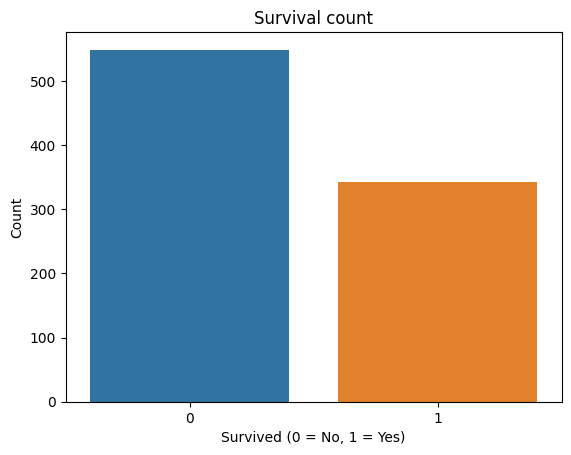

Survived
0    0.616162
1    0.383838
Name: proportion, dtype: float64


In [17]:
sns.countplot(data = train_df , x = 'Survived')
plt.title('Survival count')
plt.xlabel("Survived (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

print(train_df['Survived'].value_counts(normalize=True))    #with normalize=True it returns the percentage, otherwise just the count

Checking the survival based on the gender, the women stacked a better chance to survive against the males. 

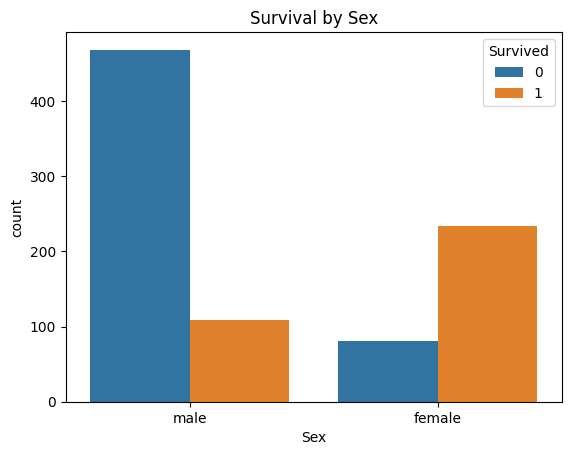

In [18]:
sns.countplot(data=train_df, x='Sex', hue='Survived')
plt.title("Survival by Sex")
plt.show()

For the next one, is something that we suspect; higher class has a better chance to survive

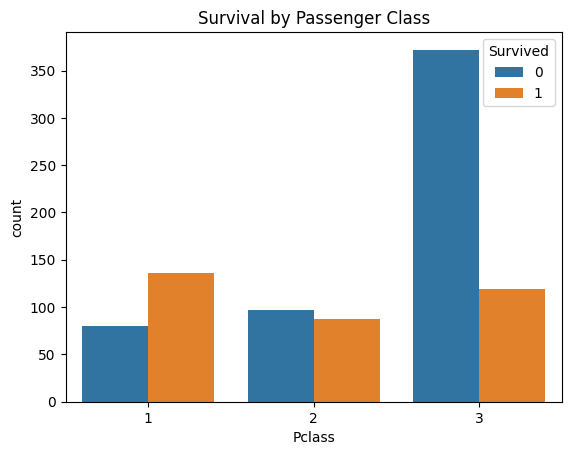

In [19]:
sns.countplot(data=train_df, x='Pclass', hue='Survived')
plt.title("Survival by Passenger Class")
plt.show()

Also, we can linked the information that describe() provided attached a boxplot. We can say that the variable `Age` doesn't have a strong relationship with survival. This doesn't imply that it might still interact with others.

<Axes: xlabel='Survived', ylabel='Age'>

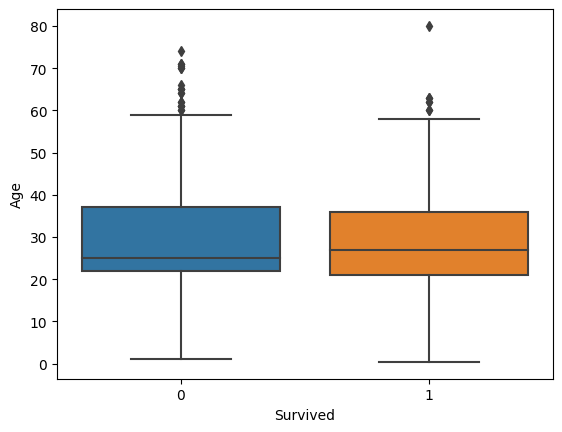

In [20]:
sns.boxplot(data=train_df, x='Survived', y='Age')

With the following code block we can tell if the two groups are different, so we got a 7.5% chance that we'd see this difference in age even if survivors and non-survivors are actually the same on average

In [21]:
group1 = train_df[train_df['Survived'] == 0]['Age'].dropna()
group2 = train_df[train_df['Survived'] == 1]['Age'].dropna()

ttest_ind(group1, group2)

TtestResult(statistic=1.7795858955791217, pvalue=0.07548530586360941, df=889.0)

Another interesting relationship that we can visualize is between Age and Pclass. To do that, I consider that it could be usefull to group the Age intro groups.

In [22]:
bins=[0,10,18,25,35,65,80]
labels=['Newborn','Child','Teen','Young Adult','Adult','Senior']
train_df['Age_groups'] = pd.cut(train_df['Age'], bins=bins, labels=labels)
test_df['Age_groups'] = pd.cut(train_df['Age'], bins=bins, labels=labels)

We clearly can see that Teen group belongs to 3rd class, opposite for Adult group that belongs to group 1st.

/tmp/ipykernel_13/2602654337.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_pclass_counts = train_df.groupby(['Age_groups', 'Pclass']).size().reset_index(name='Count')
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silenc

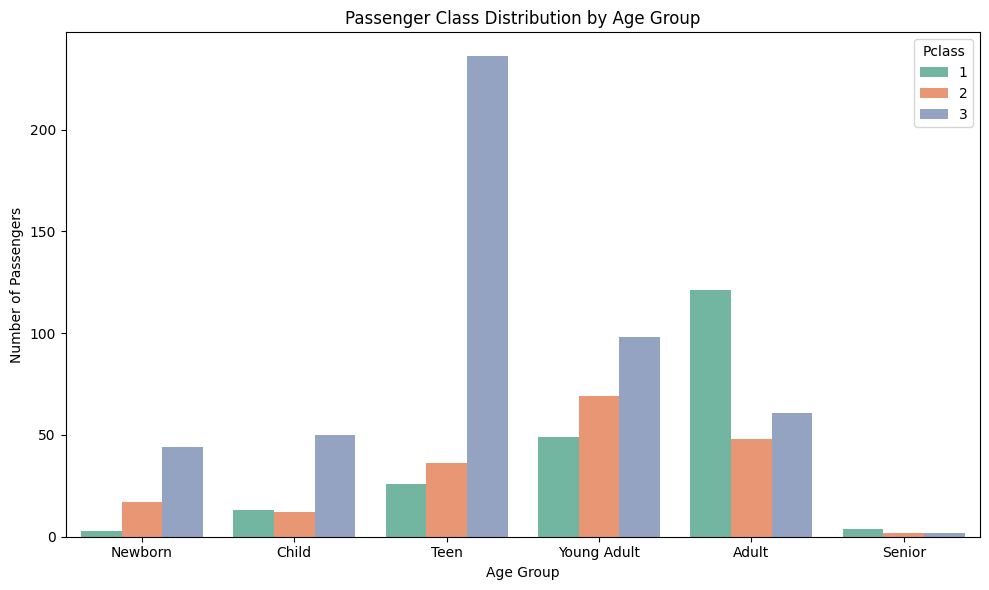

In [23]:
# Count how many passengers in each AgeGroup and Pclass
age_pclass_counts = train_df.groupby(['Age_groups', 'Pclass']).size().reset_index(name='Count')

plt.figure(figsize=(10, 6))
sns.barplot(data=age_pclass_counts, x='Age_groups', y='Count', hue='Pclass', palette='Set2')
plt.title('Passenger Class Distribution by Age Group')
plt.ylabel('Number of Passengers')
plt.xlabel('Age Group')
plt.legend(title='Pclass')
plt.tight_layout()
plt.show()

The next step to consider is a correlation matrix to have a quick check before doing feature Engineering (in case is needed)

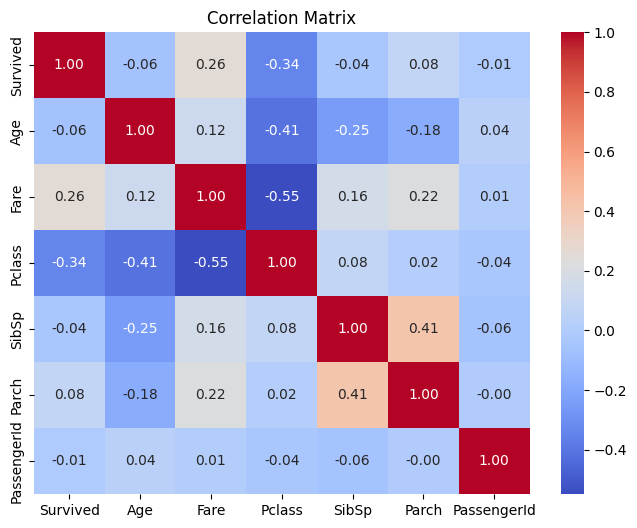

In [24]:
titanic_corr = train_df[['Survived', 'Age', 'Fare', 'Pclass', 'SibSp', 'Parch','PassengerId']].corr()

plt.figure(figsize=(8,6))
sns.heatmap(titanic_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

Let's roll on for categorical variables, and plot a Cramers'V correlation! We see that as we describe before, there is a correlation between Sex and Survival. Also, there is a less correlation but still with PClass, that it is true because in the barplot before 1st class has a better chance to survive. 

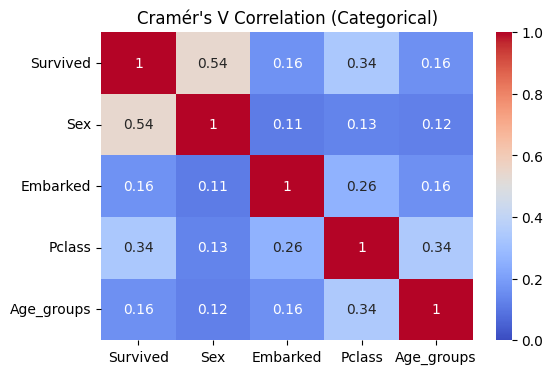

In [25]:
# Function to compute Cramér's V
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2_corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    r_corr = r - ((r-1)**2)/(n-1)
    k_corr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2_corr / min((k_corr-1), (r_corr-1)))

# Choose your categorical columns
categorical_cols = ['Survived','Sex', 'Embarked', 'Pclass','Age_groups'] 
n = len(categorical_cols)

# Create the Cramér’s V matrix
cramer_matrix = np.zeros((n, n))

for i in range(n):
    for j in range(n):
        confusion = pd.crosstab(train_df[categorical_cols[i]], train_df[categorical_cols[j]])
        cramer_matrix[i, j] = cramers_v(confusion)

# Turn into DataFrame for heatmap
cramer_df = pd.DataFrame(cramer_matrix, index=categorical_cols, columns=categorical_cols)

# Plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cramer_df, annot=True, cmap='coolwarm', vmin=0, vmax=1)
plt.title("Cramér's V Correlation (Categorical)")
plt.show()

It would be interesting to bin feature `Fare` in the same way that we did with `Age` based that on the previous Matrix, it has a slighty correlacion with the target, so let's proceed to do that!

In [26]:
bins=[0,14,30,520]
labels=['low','medium','rich']
train_df['Fare_groups'] = pd.cut(train_df['Fare'], bins=bins, labels=labels)
test_df['Fare_groups'] = pd.cut(test_df['Fare'], bins=bins, labels=labels)

/tmp/ipykernel_13/405983843.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_pclass_counts = train_df.groupby(['Fare_groups', 'Survived']).size().reset_index(name='Count')
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and sile

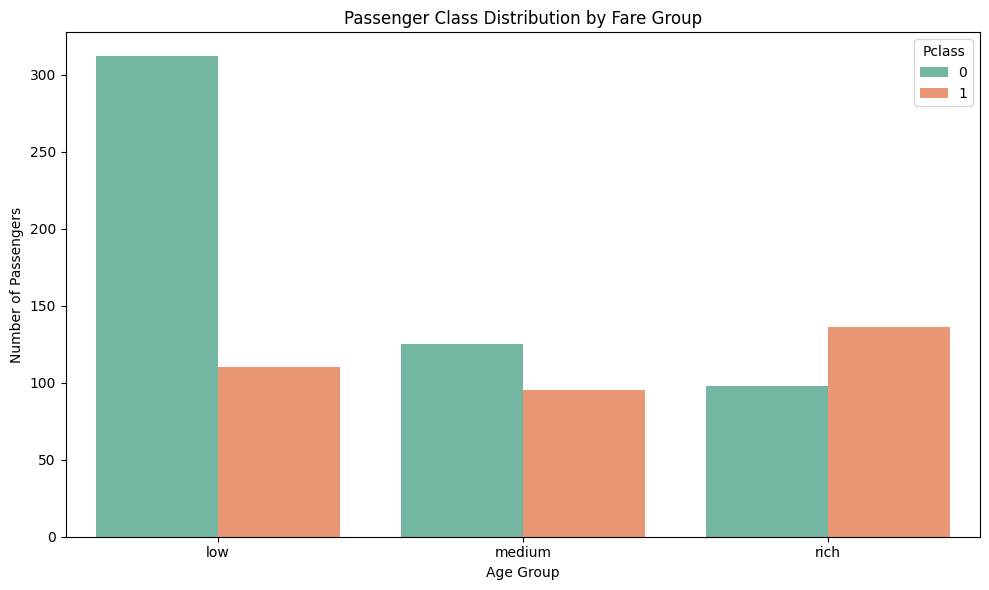

In [27]:
# Count how many passengers in each AgeGroup and Pclass
age_pclass_counts = train_df.groupby(['Fare_groups', 'Survived']).size().reset_index(name='Count')

plt.figure(figsize=(10, 6))
sns.barplot(data=age_pclass_counts, x='Fare_groups', y='Count', hue='Survived', palette='Set2')
plt.title('Passenger Class Distribution by Fare Group')
plt.ylabel('Number of Passengers')
plt.xlabel('Age Group')
plt.legend(title='Pclass')
plt.tight_layout()
plt.show()

We can replicate again the Cramer's V and see how the new features interact with the target.

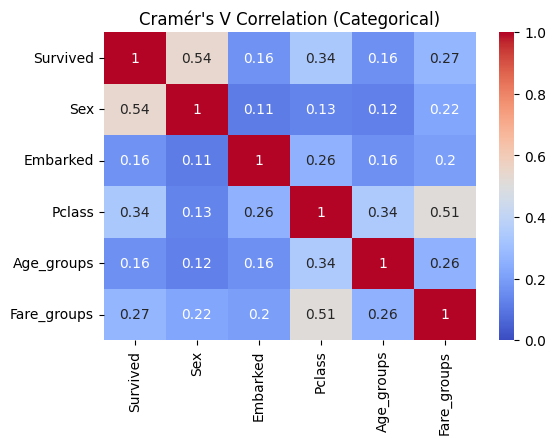

In [28]:
# Choose your categorical columns
categorical_cols = ['Survived','Sex', 'Embarked', 'Pclass','Age_groups','Fare_groups'] 
n = len(categorical_cols)

# Create the Cramér’s V matrix
cramer_matrix = np.zeros((n, n))

for i in range(n):
    for j in range(n):
        confusion = pd.crosstab(train_df[categorical_cols[i]], train_df[categorical_cols[j]])
        cramer_matrix[i, j] = cramers_v(confusion)

# Turn into DataFrame for heatmap
cramer_df = pd.DataFrame(cramer_matrix, index=categorical_cols, columns=categorical_cols)

# Plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cramer_df, annot=True, cmap='coolwarm', vmin=0, vmax=1)
plt.title("Cramér's V Correlation (Categorical)")
plt.show()

For this competition I chose RandomForestClassification, and based that we can use categorical variables I prefer to exclude Age and Fare, and include the new ones in the study.
After checking our metrics, I would perform Cross validation with GridSearch.

Let's started with CatBoost first, based that it handle categorical variables and no need to encode them. But before that, let's double check the format of each column.

Before proceed with the algorithm, we can see that for the new column `Fare_groups' it cointains some missing value.

In [29]:
train_df.info(memory_usage = "deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  891 non-null    int64   
 1   Survived     891 non-null    int64   
 2   Pclass       891 non-null    int64   
 3   Name         891 non-null    object  
 4   Sex          891 non-null    object  
 5   Age          891 non-null    float64 
 6   SibSp        891 non-null    int64   
 7   Parch        891 non-null    int64   
 8   Ticket       891 non-null    object  
 9   Fare         891 non-null    float64 
 10  Embarked     891 non-null    object  
 11  Age_groups   891 non-null    category
 12  Fare_groups  876 non-null    category
dtypes: category(2), float64(2), int64(5), object(4)
memory usage: 284.1 KB


In those cases, it matches when `Fare`= 0.0; so let's impute those values with zero, so they belongs to the first category `low`.

In [30]:
train_df[train_df['Fare_groups'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Age_groups,Fare_groups
179,180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,S,Adult,NaN
263,264,0,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0,S,Adult,NaN
271,272,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0,S,Teen,NaN
277,278,0,2,"Parkes, Mr. Francis ""Frank""",male,30.0,0,0,239853,0.0,S,Young Adult,NaN
302,303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,S,Teen,NaN
413,414,0,2,"Cunningham, Mr. Alfred Fleming",male,30.0,0,0,239853,0.0,S,Young Adult,NaN
466,467,0,2,"Campbell, Mr. William",male,30.0,0,0,239853,0.0,S,Young Adult,NaN
481,482,0,2,"Frost, Mr. Anthony Wood ""Archie""",male,30.0,0,0,239854,0.0,S,Young Adult,NaN
597,598,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,S,Adult,NaN
633,634,0,1,"Parr, Mr. William Henry Marsh",male,40.0,0,0,112052,0.0,S,Adult,NaN


In [31]:
train_df['Fare_groups'] = train_df['Fare_groups'].fillna('low')
test_df['Fare_groups'] = test_df['Fare_groups'].fillna('low')

In [32]:
train_df.info(memory_usage = "deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  891 non-null    int64   
 1   Survived     891 non-null    int64   
 2   Pclass       891 non-null    int64   
 3   Name         891 non-null    object  
 4   Sex          891 non-null    object  
 5   Age          891 non-null    float64 
 6   SibSp        891 non-null    int64   
 7   Parch        891 non-null    int64   
 8   Ticket       891 non-null    object  
 9   Fare         891 non-null    float64 
 10  Embarked     891 non-null    object  
 11  Age_groups   891 non-null    category
 12  Fare_groups  891 non-null    category
dtypes: category(2), float64(2), int64(5), object(4)
memory usage: 284.1 KB


In [33]:
train_df.drop(columns=['Age','Fare','PassengerId'],inplace=True)
train_df.head()

,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Embarked,Age_groups,Fare_groups
0,0,3,"Braund, Mr. Owen Harris",male,1,0,A/5 21171,S,Teen,low
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,1,0,PC 17599,C,Adult,rich
2,1,3,"Heikkinen, Miss. Laina",female,0,0,STON/O2. 3101282,S,Young Adult,low
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,1,0,113803,S,Young Adult,rich
4,0,3,"Allen, Mr. William Henry",male,0,0,373450,S,Young Adult,low


As we have different values for Name, those values could impact in the performance of the algorithm, based that some alias are attached to the age:

In [34]:
train_df['Title'] = train_df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
print(train_df['Title'].value_counts())

Title
Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Major         2
Col           2
Countess      1
Capt          1
Ms            1
Sir           1
Lady          1
Mme           1
Don           1
Jonkheer      1
Name: count, dtype: int64


In [35]:
#So, next step:

# You can group rare titles under 'Other'
train_df['Title'] = train_df['Title'].replace(['Lady', 'Countess','Capt', 'Col',
                                                'Don', 'Dr', 'Major', 'Rev', 'Sir', 
                                                'Jonkheer', 'Dona'], 'Other')

train_df['Title'] = train_df['Title'].replace('Mlle', 'Miss')
train_df['Title'] = train_df['Title'].replace('Ms', 'Miss')
train_df['Title'] = train_df['Title'].replace('Mme', 'Mrs')

train_df.drop('Name', axis=1, inplace=True)

In [36]:
def metrics(y_test,y_pred):
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

In [37]:
y= train_df['Survived']
X= train_df.loc[:, train_df.columns != 'Survived']

# Step 2: Identify categorical features (CatBoost uses column names or indices)
cat_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Step 3: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Step 4: Create Pool object (optional but recommended for cat features)
train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)

# Step 5: Initialize and train the model
model_cat = CatBoostClassifier(verbose=100, random_state=42, class_weights=[1,3])
model_cat.fit(train_pool)

# Step 6: Predict & evaluate
y_pred = model_cat.predict(X_test)
metrics(y_test, y_pred)

Learning rate set to 0.008672
0:	learn: 0.6883233	total: 60.5ms	remaining: 1m
100:	learn: 0.4626523	total: 322ms	remaining: 2.86s
200:	learn: 0.3950087	total: 584ms	remaining: 2.32s
300:	learn: 0.3657521	total: 845ms	remaining: 1.96s
400:	learn: 0.3478366	total: 1.1s	remaining: 1.64s
500:	learn: 0.3337046	total: 1.36s	remaining: 1.36s
600:	learn: 0.3227609	total: 1.61s	remaining: 1.07s
700:	learn: 0.3129192	total: 1.87s	remaining: 797ms
800:	learn: 0.3022035	total: 2.12s	remaining: 526ms
900:	learn: 0.2936603	total: 2.37s	remaining: 260ms
999:	learn: 0.2881988	total: 2.6s	remaining: 0us
Accuracy: 0.7803

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.77      0.81       137
           1       0.68      0.80      0.74        86

    accuracy                           0.78       223
   macro avg       0.77      0.78      0.77       223
weighted avg       0.79      0.78      0.78       223


Confusion Matrix:
[[105  32]
 [ 17  6

Wow! We can see that involving Title is really usefull, however some metrics slightly dropped down, but keep looking into data!

In [38]:
model_cat.get_feature_importance(prettified=True)

,Feature Id,Importances
0,Title,24.237462
1,Pclass,17.917903
2,Ticket,13.809100
3,Fare_groups,12.394430
4,Age_groups,10.811997
5,Embarked,10.579428
6,Sex,5.131833
7,SibSp,3.590700
8,Parch,1.527147


Next step is to try with hyperparameter in GridSearch!

In [39]:
param_grid={
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [200, 500]
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=model_cat,
    param_grid=param_grid,
    scoring='f1',  # or 'accuracy' depending on your goal
    cv=5,
    n_jobs=-1
)

# Fit the grid search
grid_search.fit(X_train, y_train, cat_features=cat_features)

# Show the best parameters and score
print("Best Params:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)

0:	learn: 0.6661140	total: 4.81ms	remaining: 958ms
100:	learn: 0.3173062	total: 284ms	remaining: 278ms
199:	learn: 0.2779074	total: 544ms	remaining: 0us
Best Params: {'depth': 6, 'iterations': 200, 'learning_rate': 0.05}
Best F1 Score: 0.7847681613322129


In [40]:
# Retrain best model
best_model = grid_search.best_estimator_
best_model.fit(train_pool)

# Predict on test set
y_pred = best_model.predict(X_test)

# Evaluate
print(classification_report(y_test, y_pred))

0:	learn: 0.6661140	total: 3.45ms	remaining: 687ms
100:	learn: 0.3173062	total: 284ms	remaining: 279ms
199:	learn: 0.2779074	total: 543ms	remaining: 0us
              precision    recall  f1-score   support

           0       0.86      0.78      0.82       137
           1       0.69      0.79      0.74        86

    accuracy                           0.78       223
   macro avg       0.77      0.79      0.78       223
weighted avg       0.79      0.78      0.79       223



There are a little improvement with the last hyperparameter, which is really small; but our final decision is to take the last model as winner. 
So, let's procced with the submission!

Remember, that our test.csv should have the same format as our train.csv

In [41]:
test_df['Title'] = test_df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
test_df['Title'] = test_df['Title'].replace(['Lady', 'Countess','Capt', 'Col',
                                                'Don', 'Dr', 'Major', 'Rev', 'Sir', 
                                                'Jonkheer', 'Dona'], 'Other')

test_df['Title'] = test_df['Title'].replace('Mlle', 'Miss')
test_df['Title'] = test_df['Title'].replace('Ms', 'Miss')
test_df['Title'] = test_df['Title'].replace('Mme', 'Mrs')

PassId = test_df['PassengerId']
test_df.drop(columns=['Name','PassengerId','Age','Fare'], axis=1, inplace=True)

In [42]:
test_df.head()

,Pclass,Sex,SibSp,Parch,Ticket,Embarked,Age_groups,Fare_groups,Title
0,3,male,0,0,330911,Q,Teen,low,Mr
1,3,female,1,0,363272,S,Adult,low,Mrs
2,2,male,0,0,240276,Q,Young Adult,low,Mr
3,3,male,0,0,315154,S,Young Adult,low,Mr
4,3,female,1,1,3101298,S,Young Adult,low,Mrs


In [43]:
# Step 6: Predict & evaluate
y_pred_f = model_cat.predict(test_df)

In [44]:
submission = pd.DataFrame({
    'PassengerId': PassId,  
    'Survived': y_pred_f.astype(int)       
})

submission.to_csv('submission.csv', index=False)